# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Speech Emotion Classification

## Problem Statement

Build a model to recognize emotion from speech using Ensemble learning

## Learning Objectives

At the end of the mini-project, you will be able to :

* extract the features from audio data
* implement ML classification algorithms individually and as Ensembles, to classify emotions
* record the voice sample and test it with trained model

## Dataset

**TESS Dataset**

The first dataset chosen for this mini-project is the [TESS](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF) (Toronto emotional speech set) dataset. It contains 2880 files.  A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses and the sets were recorded in seven different emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). Both actresses spoke English as their first language, were university educated, and had musical training. Audiometric testing indicated that both actresses had thresholds within the normal range.

**Ravdess Dataset**

The second dataset chosen for this mini-project is [Ravdess](https://zenodo.org/record/1188976#.YLczy4XivIU) (The Ryerson Audio-Visual Database of Emotional Speech and Song). This dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

**File naming convention**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

**Filename identifiers**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: `03-01-06-01-02-01-12.wav`

    - Audio-only - 03
    - Speech - 01
    - Fearful - 06
    - Normal intensity - 01
    - Statement "dogs" - 02
    - 1st Repetition - 01
    - 12th Actor - 12 Female, as the actor ID number is even.

## Information

**Speech Emotion Recognition (SER)** is the task of recognizing the emotion from  speech, irrespective of the semantics. Humans can efficiently perform this task as a natural part of speech communication, however, the ability to conduct it automatically using programmable devices is a field of active research.

Studies of automatic emotion recognition systems aim to create efficient, real-time methods of detecting the emotions of mobile phone users, call center operators and customers, car drivers, pilots, and many other human-machine communication users. Adding emotions to machines forms an important aspect of making machines appear and act in a human-like manner

Lets gain familiarity with some of the audio based features that are commonly used for SER.

**Mel scale** — The mel scale (derived from the word *melody*) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments. Refer [here](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8) for more detailed information.

**Pitch** — how high or low a sound is. It depends on frequency, higher pitch is high frequency

**Frequency** — speed of vibration of sound, measures wave cycles per second

**Chroma** — Representation for audio where spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma). Computed by summing the log frequency magnitude spectrum across octaves.

**Fourier Transforms** — used to convert from time domain to frequency domain. Time domain shows how signal changes over time. Frequency domain shows how much of the signal lies within each given frequency band over a range of frequencies

**Librosa**

[Librosa](https://librosa.org/doc/latest/index.html) is a Python package, built for speech and audio analytics. It provides modular functions that simplify working with audio data and help in achieving a wide range of applications such as identification of the personal characteristics of different individuals' voice samples, detecting emotions from audio samples etc.

For further details on the Librosa package, refer [here](https://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf).


### **Kaggle Competition**

Please refer to the link for viewing the
[Kaggle Competition Document](https://drive.google.com/file/d/1kGJfpEC9dayjApciCYZr04NWT7XWkRhV/view?usp=sharing) and join the Kaggle Competition using the hyperlink given in this document under '*Kaggle* Competition site'.


## Grading = 10 Points

In [1]:
#@title Download the datasets and install packages
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Ravdess_Tess.zip
!unzip -qq Ravdess_Tess.zip -d output_dir/
# Install packages
!pip -qq install librosa soundfile
!pip -qq install wavio
print("Datasets downloaded successfully!")

Datasets downloaded successfully!


### Import Neccesary Packages

In [2]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import IPython.display as ipd
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import warnings
warnings.filterwarnings('ignore')
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier

### Work-Flow

* Load the TESS audio data and extract features and labels

* Load the Ravdess audio data and extract features

* Combine both the audio dataset features

* Train and test the model with TESS + Ravdess Data

* Record the team audio samples and add them to TESS + Ravdess data

* Train and test the model with TESS + Ravdess + Team Recorded (combined) data

* Test each of the models with live audio sample recording.

### Load the Tess data and Ravdess data audio files (1 point)

Hint: `glob.glob`

In [19]:
# Directory where TESS dataset is located
tess_dir = "output_dir"

# Function to load TESS audio data
def load_tess_data(tess_dir):
    # Initialize lists to store audio data and corresponding labels
    audio_data = []

    # Use glob to find all .wav files in the directory and its subdirectories
    file_paths = glob.glob(os.path.join(tess_dir, "**", "*.wav"), recursive=True)

    # Iterate over each file
    for file_path in file_paths:
        # Load audio data using librosa
        y, sr = librosa.load(file_path, sr=None)  # sr=None to preserve original sampling rate
        # Append audio data and label to lists
        audio_data.append(y)

    return audio_data

In [20]:
ravdess_tess_audio_files = load_tess_data(tess_dir)


In [13]:
len(ravdess_tess_audio_files)

3847

#### Play the sample audio

In [24]:
import IPython.display as ipd

# Assuming you've already loaded the TESS audio data
# Let's say you want to play the first audio sample
sample_audio = ravdess_tess_audio_files[0]
sample_sr = 22050  # Assuming a sample rate of 22050 Hz

# Play the sample audio
ipd.Audio(sample_audio, rate=sample_sr)


### Data Exploration and Visualization (1 point)

#### Visualize the distribution of all the labels

In [42]:
# Directory where TESS dataset is located
tess_dir = "output_dir"

# Function to extract labels from filenames
def extract_labels_from_filenames(tess_dir):
    # Initialize an empty list to store labels
    labels = []

    # Use glob to find all .wav files in the directory and its subdirectories
    file_paths = glob.glob(os.path.join(tess_dir, "**", "*.wav"), recursive=True)

    # Iterate over each file
    for file_path in file_paths:
        # Extract filename
        filename = os.path.basename(file_path)
        # Split filename by "-" to get parts
        parts = filename.split("-")
        if(len(parts) == 7):
          # Extract relevant parts (emotion, intensity, etc.) based on position in filename
          emotion = parts[2]  #  emotion is at position 2
          intensity = parts[3]  #  intensity is at position 3
        else:
          emotion = 'na'
          intensity = 'na'

        # Append extracted labels as a dictionary
        labels.append({
          'filename': filename,
          'emotion': emotion,
          'intensity': intensity,
        })

    return labels

# Extract labels from filenames
tess_labels = extract_labels_from_filenames(tess_dir)

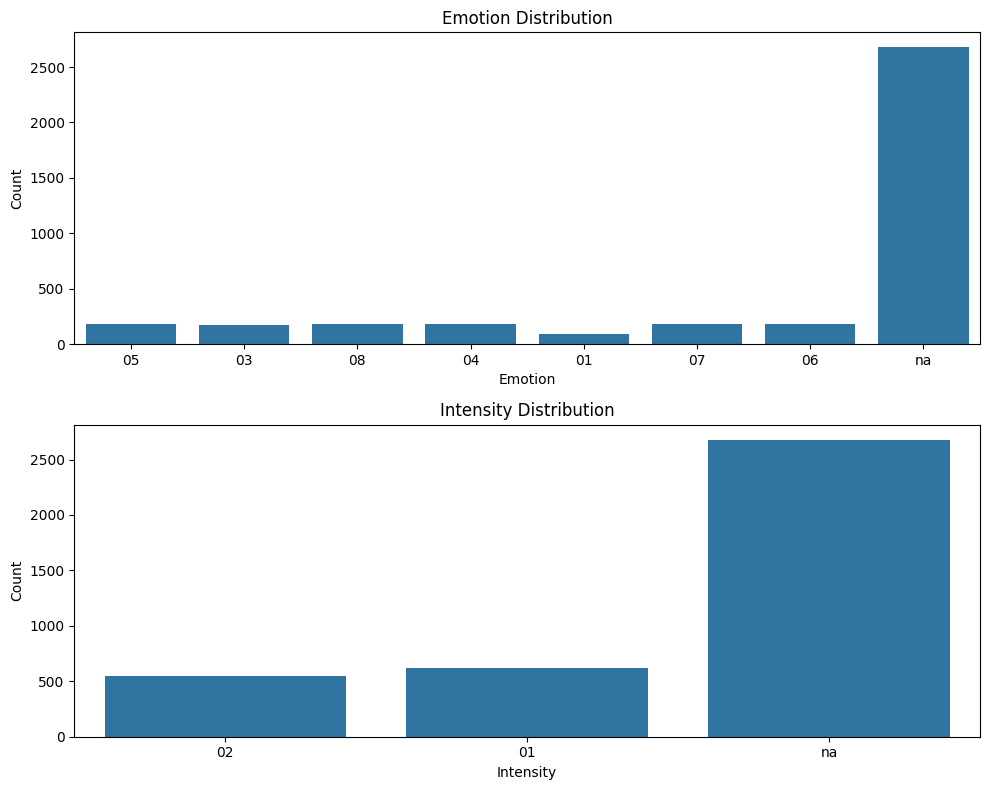

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize the distribution of labels
def visualize_label_distribution(labels):
    # Extract relevant labels for visualization
    emotions = [label['emotion'] for label in labels]
    intensities = [label['intensity'] for label in labels]

    # Create subplots for emotion and intensity distributions
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

    # Plot emotion distribution
    sns.countplot(x=emotions, ax=axes[0])
    axes[0].set_title('Emotion Distribution')
    axes[0].set_xlabel('Emotion')
    axes[0].set_ylabel('Count')

    # Plot intensity distribution
    sns.countplot(x=intensities, ax=axes[1])
    axes[1].set_title('Intensity Distribution')
    axes[1].set_xlabel('Intensity')
    axes[1].set_ylabel('Count')

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()

# Visualize label distribution
visualize_label_distribution(tess_labels)


#### Visualize sample audio signal using librosa

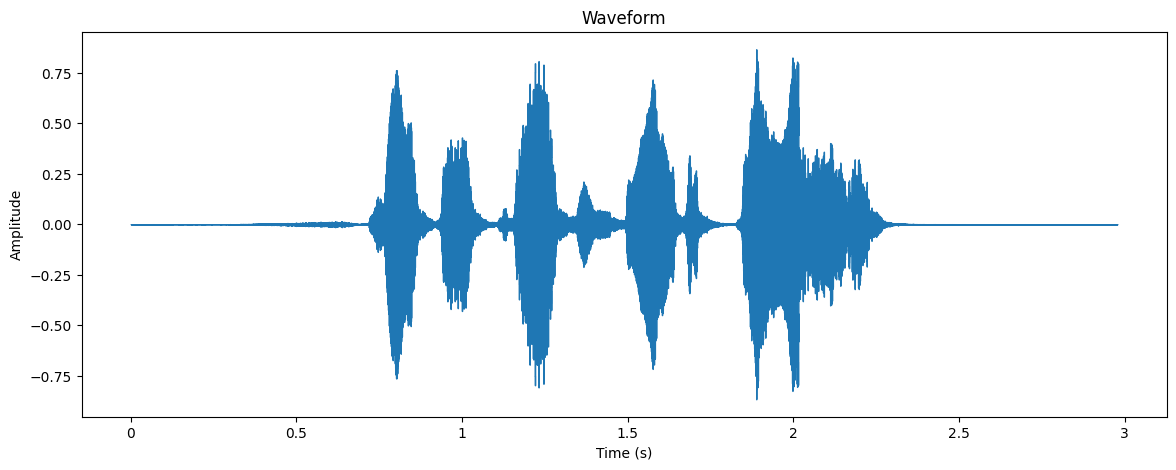

In [28]:
sample_audio_file = ravdess_tess_audio_files[0]

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_audio_file, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

### Feature extraction (2 points)

Read one WAV file at a time using `Librosa`. An audio time series in the form of a 1-dimensional array for mono or 2-dimensional array for stereo, along with time sampling rate (which defines the length of the array), where the elements within each of the arrays represent the amplitude of the sound waves is returned by `librosa.load()` function. Refer to the supplementary notebook ('Audio feature extraction')

To know more about Librosa, explore the [link](https://librosa.org/doc/latest/feature.html)

#### Create a dictionary or a function to encode the emotions

In [ ]:
def encode_emotions():
  emotion_encoding = {
      'neutral': 0,
      'calm': 1,
      'happy': 2,
      'sad': 3,
      'angry': 4,
      'fearful': 5,
      'disgust': 6,
      'surprised': 7
  }

  return emotion_encoding

#### TESS data feature extraction

In [ ]:
# YOUR CODE HERE

#### Ravdess data feature extraction

In [ ]:
# YOUR CODE HERE

#### Save the features

It is best advised to save the features in dataframe and maintain so that feature extraction step is not required to be performed every time.

* Make a DataFrame with features and labels

* Write dataframe into `.CSV` file and save it offline.

In [ ]:
# YOUR CODE HERE

#### Split the data into train and test

In [ ]:
# YOUR CODE HERE

### Train the model with TESS + Ravdess data (2 points)

* Apply different ML algorithms (eg. DecisionTree, RandomForest, etc.) and find the model with best performance

In [ ]:
# YOUR CODE HERE

#### Apply the voting classifier

In [ ]:
# YOUR CODE HERE

### Train the model with TESS + Ravdess + Team recorded data (4 points)

* Record the audio samples (team data), extract features and combine with TESS + Ravdess data features
  - Record and gather all the team data samples with proper naming convention in separate folder

    **Hint:** Follow the supplementary notebook to record team data

  - Each team member must record 2 samples for each emotion (Use similar sentences as given in TESS data)

* Train the different ML algorithms and find the model with best performance

#### Load the team data

In [ ]:
# YOUR CODE HERE

#### Extracting features of team data and combine with TESS + Ravdess

In [ ]:
# YOUR CODE HERE

#### Train the different ML algorithms

In [ ]:
# YOUR CODE HERE

#### Test the best working model with live audio recording

In [ ]:
# choose the best working model and assign below
MODEL =

In [ ]:
#@title Speak the utterance and test
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

if not os.path.exists('ModelTesting/'):
    os.mkdir("ModelTesting/")
def record(sec=3):
    print("Start speaking!")
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    with open('ModelTesting/audio_'+current_time+'.wav','wb') as f:
        f.write(b)
    return 'ModelTesting/audio_'+current_time+'.wav'
test_i = record()
pred = MODEL.predict(extract_feature(test_i).reshape(1,-1))
idx_emotion = list(emotions.values()).index(pred[0])
print(list(emotions.keys())[idx_emotion])
ipd.Audio(test_i)

### Report Analysis

- Report the accuracy for 10 live samples using the model trained on TESS+Ravdess+Team data
- Discuss with the team mentor regarding deep learnt audio features. Read a related article [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8805181).
